In [1]:
import torch
from constants import TRAIN_TRANSFORM, batch_size, latent_dim, lr, epochs
from torch.utils.data import random_split, DataLoader

from model import VAE
from dataset import CelebADataset
from scoring import get_fid_score
import numpy as np
from utils import get_tsne, plot_representation
import pandas as pd
from torchmetrics.image.fid import FrechetInceptionDistance

In [2]:
# df = pd.read_csv('./data/list_attr_celeba.csv')
# df = df.replace(to_replace=-1, value=0)

# # list the columns
# print(df.columns)

In [3]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Load and split the CelebA dataset
celeba_data_path = './data/img_align_celeba/img_align_celeba/'

dataset = CelebADataset(celeba_data_path, transform=TRAIN_TRANSFORM)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

# Create the VAE model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Number of images: 101299


In [4]:
model = VAE(latent_dim).to(device)

model.load_state_dict(torch.load('./saved_models/vae.pth'))
encoder = model.encoder
encoder = encoder.to(device)

model.eval()
encoder.eval()

Encoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=128, bias=True)
)

Batch 1/80
Batch 6/80
Batch 11/80
Batch 16/80
Batch 21/80
Batch 26/80
Batch 31/80
Batch 36/80
Batch 41/80
Batch 46/80
Batch 51/80
Batch 56/80
Batch 61/80
Batch 66/80
Batch 71/80
Batch 76/80
FID score: 166.8020


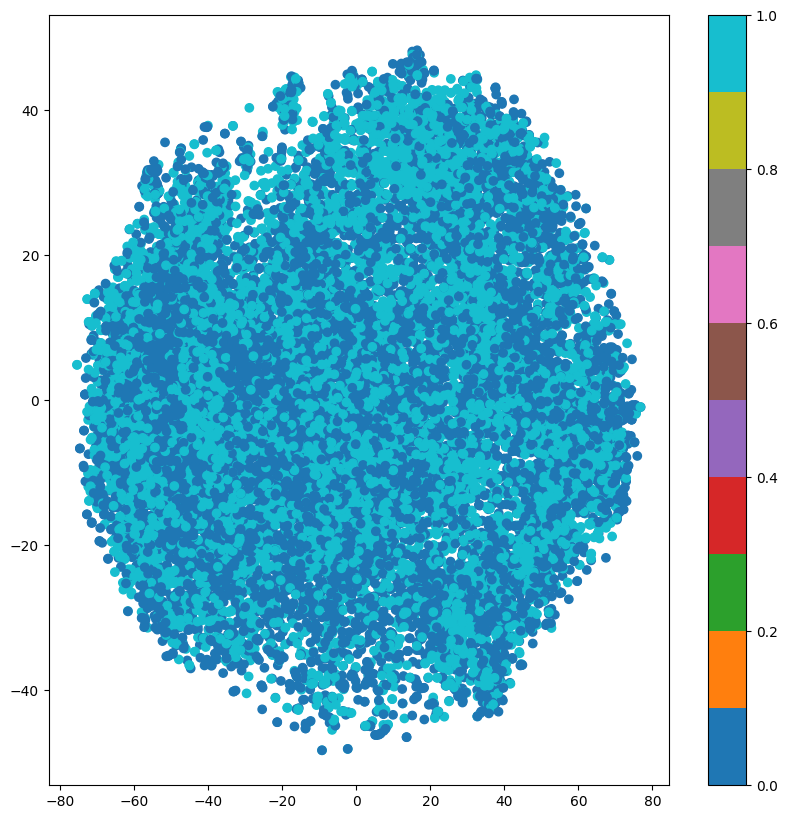

In [5]:
fid_score = FrechetInceptionDistance(n_features=64).to(device)

latent_rep = []
labels = []

with torch.no_grad():
    for i, (imgs, label) in enumerate(val_loader):
        imgs = imgs.to(device)
        x, _, _ = encoder(imgs)
        latent_rep.append(x.cpu().numpy())
        labels.append(label)
        z, _, _ = model(imgs)

        fid_score = get_fid_score(fid_score, imgs, z)

        if i % 5 == 0:
            print(f'Batch {i+1}/{len(val_loader)}')

print(f'FID score: {fid_score.compute():.4f}')

labels = np.concatenate(labels, axis=0)
latent_rep = np.concatenate(latent_rep, axis=0)

tsne = get_tsne(latent_rep, no_components=2)

plot_representation(latent_rep=tsne, labels=labels)